In [6]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from torch.utils.data import DataLoader
from utils.cnn_rnn import CNN_RNN_Model
from utils.Prepare_data import WikiArtDataset 
import os

In [8]:
#load the model from the cnn_rnn and the with the weights of the last epcohs
def load_model(model_path, input_size=1032, hidden_size=256, num_classes=23, device="cuda"):
    model = CNN_RNN_Model(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"[INFO] Model loaded from {model_path}")
    return model

In [9]:
def evaluate(task_name, model_path, csv_file, class_mapping, device="cuda"):
    model = load_model(model_path, num_classes=len(class_mapping), device=device)
    dataset = WikiArtDataset(csv_file)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

    y_true, y_pred = [], []
    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Save 
    report = classification_report(y_true, y_pred, target_names=class_mapping.values())
    with open(f"{task_name}_classification_report.txt", "w") as f:
        f.write(report)
    
    with open(f"{task_name}_scores.txt", "w") as f:
        f.write(f"Accuracy: {accuracy}\n")
        f.write(f"Precision: {precision}\n")
        f.write(f"Recall: {recall}\n")
        f.write(f"F1 Score: {f1}\n")
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{task_name.capitalize()} Confusion Matrix')
    plt.savefig(f"{task_name}_confusion.png")
    plt.close()
    
    print(f"[INFO] Evaluation results saved for {task_name}")

In [11]:
#for artist
base_dir = os.getcwd()    
model_path = os.path.join(base_dir, "artist_weights", "cnn_rnn_epoch_20.pth")
csv_file = os.path.join(base_dir, "eval_data", "csv", "artist.csv")  
task_name = "artist" 
    
class_mapping = {
    0: "Albrecht_Durer", 1: "Boris_Kustodiev", 2: "Camille_Pissarro", 3: "Childe_Hassam",
    4: "Claude_Monet", 5: "Edgar_Degas", 6: "Eugene_Boudin", 7: "Gustave_Dore",
    8: "Ilya_Repin", 9: "Ivan_Aivazovsky", 10: "Ivan_Shishkin", 11: "John_Singer_Sargent",
    12: "Marc_Chagall", 13: "Martiros_Saryan", 14: "Nicholas_Roerich", 15: "Pablo_Picasso",
    16: "Paul_Cezanne", 17: "Pierre_Auguste_Renoir", 18: "Pyotr_Konchalovsky", 19: "Raphael_Kirchner",
    20: "Rembrandt", 21: "Salvador_Dali", 22: "Vincent_van_Gogh"
    }
    
evaluate(task_name, model_path, csv_file, class_mapping)

[INFO] Model loaded from /media/neelkamal/dca5b7c5-7f3f-4cbd-b82d-03706cafddf6/Atharva/HumanAI/task1/artist_weights/cnn_rnn_epoch_20.pth
[INFO] Loaded 460 samples from /media/neelkamal/dca5b7c5-7f3f-4cbd-b82d-03706cafddf6/Atharva/HumanAI/task1/eval_data/csv/artist.csv
[INFO] Dataset contains 23 unique classes
[INFO] Loading ConvNeXt model...
[INFO] ConvNeXt model loaded successfully
[INFO] Testing feature extraction pipeline...
[INFO] Gabor features shape: (8, 7, 7)
[INFO] ConvNeXt features shape: (1024, 7, 7)
[INFO] Final sequence shape: torch.Size([49, 1032])
[INFO] Feature extraction pipeline verified successfully!
[INFO] Evaluation results saved for artist


In [12]:
def display_confusion_matrix(image_path, task_name):
    
    if os.path.exists(image_path):
        plt.figure(figsize=(10, 8))
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{task_name.capitalize()} Confusion Matrix")
        plt.show()
    else:
        print(f"[ERROR] Confusion matrix image not found: {image_path}")

def display_text_file(file_path, title):

    if os.path.exists(file_path):
        print(f"\n{title}:\n" + "-" * len(title))
        with open(file_path, "r") as f:
            print(f.read())
    else:
        print(f"[ERROR] File not found: {file_path}")
        
def load_and_display_results(task_name):
    base_dir = os.getcwd()
    confusion_matrix_path = os.path.join(base_dir, f"{task_name}_confusion.png")
    classification_report_path = os.path.join(base_dir, f"{task_name}_classification_report.txt")
    scores_path = os.path.join(base_dir, f"{task_name}_scores.txt")

    display_confusion_matrix(confusion_matrix_path, task_name)

    display_text_file(classification_report_path, f"Classification Report for {task_name.capitalize()}")
    
    display_text_file(scores_path, f"Scores for {task_name.capitalize()}")


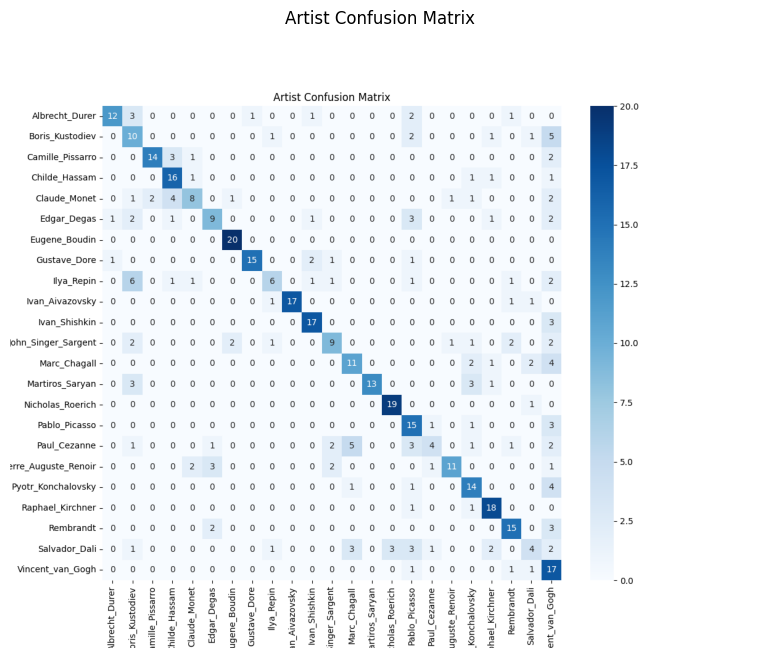


Classification Report for Artist:
--------------------------------
                       precision    recall  f1-score   support

       Albrecht_Durer       0.86      0.60      0.71        20
      Boris_Kustodiev       0.34      0.50      0.41        20
     Camille_Pissarro       0.88      0.70      0.78        20
        Childe_Hassam       0.64      0.80      0.71        20
         Claude_Monet       0.62      0.40      0.48        20
          Edgar_Degas       0.60      0.45      0.51        20
        Eugene_Boudin       0.87      1.00      0.93        20
         Gustave_Dore       0.94      0.75      0.83        20
           Ilya_Repin       0.60      0.30      0.40        20
      Ivan_Aivazovsky       1.00      0.85      0.92        20
        Ivan_Shishkin       0.77      0.85      0.81        20
  John_Singer_Sargent       0.60      0.45      0.51        20
         Marc_Chagall       0.55      0.55      0.55        20
      Martiros_Saryan       1.00      0.65      0

In [13]:
task_name = "artist" 
load_and_display_results(task_name)


In [ ]:
#for genre
base_dir = os.getcwd()    

model_path = os.path.join(base_dir, "weights", "cnn_rnn_epoch_9.pth")

csv_file = os.path.join(base_dir, "eval_data", "csv", "genre.csv")  
task_name = "genre" 
    
class_mapping = {
        0: "abstract_painting",
        1: "cityscape",
        2: "genre_painting",
        3: "illustration",
        4: "landscape",
        5: "nude_painting",
        6: "portrait",
        7: "religious_painting",
        8: "sketch_and_study",
        9: "still_life"
    }
    
evaluate(task_name, model_path, csv_file, class_mapping)

[INFO] Model loaded from /media/neelkamal/dca5b7c5-7f3f-4cbd-b82d-03706cafddf6/Atharva/HumanAI/task1/weights/cnn_rnn_epoch_9.pth
[INFO] Loaded 1000 samples from /media/neelkamal/dca5b7c5-7f3f-4cbd-b82d-03706cafddf6/Atharva/HumanAI/task1/eval_data/csv/genre.csv
[INFO] Dataset contains 10 unique classes
[INFO] Loading ConvNeXt model...
[INFO] ConvNeXt model loaded successfully
[INFO] Testing feature extraction pipeline...
[INFO] Gabor features shape: (8, 7, 7)
[INFO] ConvNeXt features shape: (1024, 7, 7)
[INFO] Final sequence shape: torch.Size([49, 1032])
[INFO] Feature extraction pipeline verified successfully!
[INFO] Evaluation results saved for genre


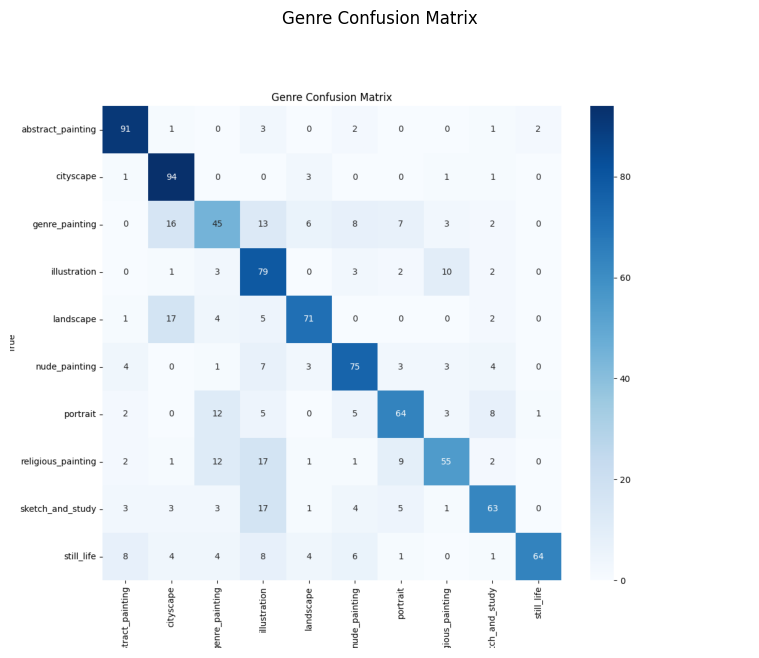


Classification Report for Genre:
-------------------------------
                    precision    recall  f1-score   support

 abstract_painting       0.81      0.91      0.86       100
         cityscape       0.69      0.94      0.79       100
    genre_painting       0.54      0.45      0.49       100
      illustration       0.51      0.79      0.62       100
         landscape       0.80      0.71      0.75       100
     nude_painting       0.72      0.75      0.74       100
          portrait       0.70      0.64      0.67       100
religious_painting       0.72      0.55      0.62       100
  sketch_and_study       0.73      0.63      0.68       100
        still_life       0.96      0.64      0.77       100

          accuracy                           0.70      1000
         macro avg       0.72      0.70      0.70      1000
      weighted avg       0.72      0.70      0.70      1000


Scores for Genre:
----------------
Accuracy: 0.701
Precision: 0.718100227466014
Recall: 0.

In [19]:
task_name = "genre" 
load_and_display_results(task_name)

In [ ]:
#for artist
base_dir = os.getcwd()    

model_path = os.path.join(base_dir, "style_weights", "cnn_rnn_epoch_10.pth")

csv_file = os.path.join(base_dir, "eval_data", "csv", "style.csv")  
task_name = "style" 
    
class_mapping = {
    0: "Abstract Expressionism",
    1: "Action Painting",
    2: "Analytical Cubism",
    3: "Art Nouveau",
    4: "Baroque",
    5: "Color Field Painting",
    6: "Contemporary Realism",
    7: "Cubism",
    8: "Early Renaissance",
    9: "Expressionism",
    10: "Fauvism",
    11: "High Renaissance",
    12: "Impressionism",
    13: "Mannerism / Late Renaissance",
    14: "Minimalism",
    15: "Naïve Art / Primitivism",
    16: "New Realism",
    17: "Northern Renaissance",
    18: "Pointillism",
    19: "Pop Art",
    20: "Post-Impressionism",
    21: "Realism",
    22: "Rococo",
    23: "Romanticism",
    24: "Symbolism",
    25: "Synthetic Cubism",
    26: "Ukiyo-e"
}

    
evaluate(task_name, model_path, csv_file, class_mapping)

[INFO] Model loaded from /media/neelkamal/dca5b7c5-7f3f-4cbd-b82d-03706cafddf6/Atharva/HumanAI/task1/style_weights/cnn_rnn_epoch_10.pth
[INFO] Loaded 675 samples from /media/neelkamal/dca5b7c5-7f3f-4cbd-b82d-03706cafddf6/Atharva/HumanAI/task1/eval_data/csv/style.csv
[INFO] Dataset contains 27 unique classes
[INFO] Loading ConvNeXt model...
[INFO] ConvNeXt model loaded successfully
[INFO] Testing feature extraction pipeline...
[INFO] Gabor features shape: (8, 7, 7)
[INFO] ConvNeXt features shape: (1024, 7, 7)
[INFO] Final sequence shape: torch.Size([49, 1032])
[INFO] Feature extraction pipeline verified successfully!
[INFO] Evaluation results saved for style


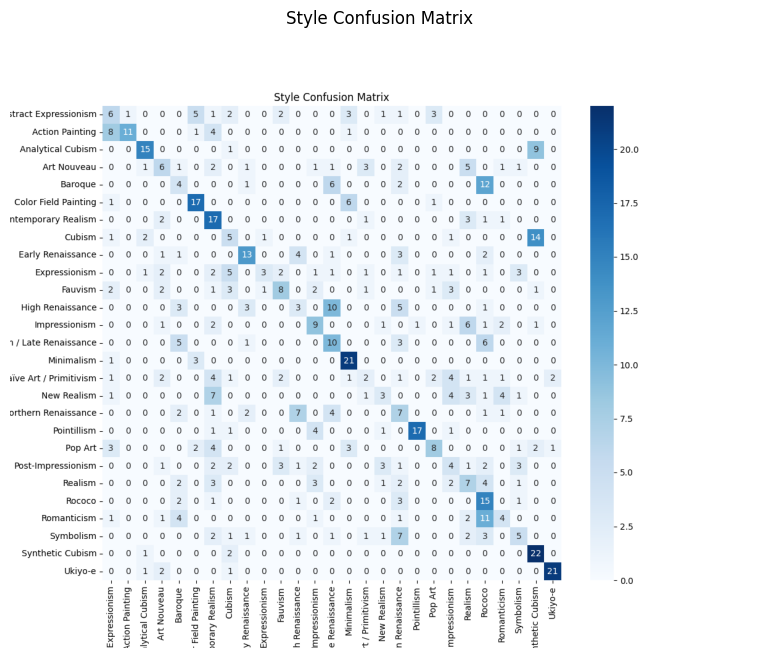


Classification Report for Style:
-------------------------------
                              precision    recall  f1-score   support

      Abstract Expressionism       0.24      0.24      0.24        25
             Action Painting       0.92      0.44      0.59        25
           Analytical Cubism       0.71      0.60      0.65        25
                 Art Nouveau       0.30      0.24      0.27        25
                     Baroque       0.17      0.16      0.16        25
        Color Field Painting       0.61      0.68      0.64        25
        Contemporary Realism       0.31      0.68      0.43        25
                      Cubism       0.21      0.20      0.20        25
           Early Renaissance       0.59      0.52      0.55        25
               Expressionism       0.60      0.12      0.20        25
                     Fauvism       0.44      0.32      0.37        25
            High Renaissance       0.18      0.12      0.14        25
               Impressi

In [22]:
task_name = "style" 
load_and_display_results(task_name)